In [50]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm

import pickle

import scipy.special

import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds

import parameters

from delfi.simulator.Gauss import Gauss

In [2]:
def plot_family(dists, target=None, limts=[-5, 5], labels=None, title=None):
    xlist = np.linspace(-5, 5, 200)
    
    fig, (axpdf) = plt.subplots(1, figsize=(8, 6))
    
    if title is not None:
        fig.suptitle(title)
        
    ndists = len(dists)
    if labels is None:
        labels = [ None for i in range(ndists) ]
        
    cmap = plt.get_cmap('viridis')#cm.viridis
    colors = [cmap(i) for i in np.linspace(0, 1, ndists)]
    
    for i in range(0, ndists):
        d = dists[i]
        ylist = d.eval(xlist.reshape((-1,1)), log=False)
        axpdf.plot(xlist, ylist, label=labels[i], c=colors[i])#, c=[0,1 - i / ndists,0])
    
    if target is not None:
        ylist = target.eval(xlist.reshape((-1,1)), log=False)
        axpdf.plot(xlist, ylist, label="Target", c='r')
        
    box = axpdf.get_position()
    axpdf.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    axpdf.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [46]:
default_params = parameters.ParameterSet({})

default_params.seed = 420

default_params.n_train = 5000
default_params.n_rounds = 1
default_params.proposal = None
default_params.round_cl = 5

default_params.true_params = [0]
default_params.obs_stats = [[0]]

# The actual prior variance
default_params.prior_var = 4

default_params.noise_cov = 0.1

default_params.n_qtest = 1000

In [32]:
def run(params):
    m = Gauss(dim=1, noise_cov=params.noise_cov, seed=params.seed)
    p = dd.Gaussian(m=[0], S=[[params.prior_var]], seed=params.seed)
    s = ds.Identity()

    g = dg.MPGenerator(models=[m], prior=p, summary=s)

    res = infer.SNPE(g, 
                     obs=params.obs_stats,
                     seed=params.seed, 
                     pilot_samples=None,
                     convert_to_T=False,
                     svi=False)
    
    res.run(n_train=params.n_train, 
            n_rounds=params.n_rounds, 
            minibatch=100, 
            epochs=1000, 
            round_cl=params.round_cl,
            proposal = params.proposal)
    
    return m, p, s, res

In [33]:
model, prior, summ, net = run(default_params)

Process Worker-5:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/kaan/delfi/delfi/generator/MPGenerator.py", line 29, in run
    params_batch = self.conn.recv()
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [43]:
def estimate_quantile(model, prior, summ, net, L=1000):
    theta = prior.gen()
    y = model.gen_single(theta)
    stats = summ.calc([y])
    
    posterior = net.predict(stats)
    
    post_thetas = posterior.gen(n_samples=L)
    
    est_quantile = 1 / L * np.count_nonzero(theta[0,0] > post_thetas[:,0])
    return est_quantile

In [51]:
quantiles = []

for i in tqdm(range(default_params.n_qtest)):
    quantiles.append(estimate_quantile(model, prior, summ, net))

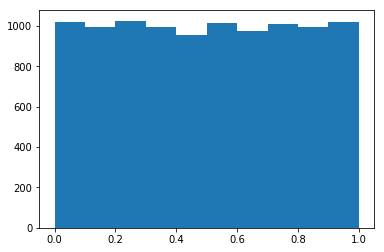

In [53]:
fig = plt.figure()
ax = plt.subplot(111)

ax.hist(quantiles)

plt.show()